In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.conv_learner import *
import fastai.custom_extensions

In [10]:
# architecture variables
PATH = "data/tree_identifier/"
train_path = f'{PATH}train/'
valid_path = f'{PATH}valid/'

arch=resnet34
sz=128
bs=16
filename='resnet34'

In [12]:
!ls {PATH}

models	tmp  train  TreeIdentifier.zip	valid


### Clean up Bad Data

In [19]:
# Remove .gifs
# paths = !find {PATH} -name '*.gif'

# find all files not ending in .jpg or .JPG
paths = !find {PATH} -not -name "*.jpg" -not -name "*.JPG" -type f
paths

['data/tree_identifier/TreeIdentifier.zip',
 'data/tree_identifier/valid/Torrey pine tree/1. torrey-pine-tree.png',
 'data/tree_identifier/valid/Torrey pine tree/17. torrey-pine-trees-guide.png',
 'data/tree_identifier/valid/Leather oak tree/19. image606.png',
 'data/tree_identifier/models/tmp.h5',
 'data/tree_identifier/train/Coast live oak tree/15. ar129579683976933.png',
 'data/tree_identifier/train/Coast live oak tree/20. quercus-agrifolia-1.png',
 'data/tree_identifier/train/Blue oak tree/2. Blue-Oak-min.png',
 'data/tree_identifier/train/Torrey pine tree/2. torrey-pine-trees.png',
 'data/tree_identifier/train/Leather oak tree/12. leather-oak-med.png',
 'data/tree_identifier/train/Mountain hemlock tree/5. Tsuga-mertensiana-cluster.png',
 'data/tree_identifier/train/Port Orford cedar-Lawson cypress tree/9. sullivan_port_orford-cedar_0945.png',
 'data/tree_identifier/train/Gray pine tree/13. gray-pine-tree-hi.png']

In [20]:
for p in paths:
    print(p)
    # need to format filename with escaped spaces \
    !rm {p.replace(' ', '\ ')}

data/tree_identifier/TreeIdentifier.zip
data/tree_identifier/valid/Torrey pine tree/1. torrey-pine-tree.png
data/tree_identifier/valid/Torrey pine tree/17. torrey-pine-trees-guide.png
data/tree_identifier/valid/Leather oak tree/19. image606.png
data/tree_identifier/models/tmp.h5
data/tree_identifier/train/Coast live oak tree/15. ar129579683976933.png
data/tree_identifier/train/Coast live oak tree/20. quercus-agrifolia-1.png
data/tree_identifier/train/Blue oak tree/2. Blue-Oak-min.png
data/tree_identifier/train/Torrey pine tree/2. torrey-pine-trees.png
data/tree_identifier/train/Leather oak tree/12. leather-oak-med.png
data/tree_identifier/train/Mountain hemlock tree/5. Tsuga-mertensiana-cluster.png
data/tree_identifier/train/Port Orford cedar-Lawson cypress tree/9. sullivan_port_orford-cedar_0945.png
data/tree_identifier/train/Gray pine tree/13. gray-pine-tree-hi.png


In [23]:
# Remove files which arent images
def remove_file(fname):
    print(fname)
    !rm {fname}
   
def clean_data(dir):
    files = [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]
    for img in files:
        try: 
            PIL.Image.open(PATH+img)
        except IOError as error:
            str = error.args[0][27:]
            fname = re.sub(r'\\\\(.)', r'\1', str)
            # needs to be unescaped
            remove_file(fname)
            
clean_data(train_path)

### Split apart validation set from training data

In [ ]:
def split_valid_set(dir,new_dir,per=0.2):
    files = os.listdir(dir)
    random.shuffle(files)
    n = len(files)
    num = int(per*n)
    for i in range(num):
        file = files[i]
        os.rename(dir+file, new_dir+file)

# create valid/ if doesn't already exist
os.makedirs(f'{PATH}valid/', exist_ok=True)

# iterate through training directories
for dir in os.listdir(train_path):
    # print(os.path.join(train_path, dir))
    # Create a new directory in valid/
    os.makedirs(f'{valid_path}{dir}/', exist_ok=True)
    split_valid_set(f'{train_path}{dir}/', f'{valid_path}{dir}/')

In [23]:
# find all files (not directories)
!find {train_path} -type f | wc -l
!find {valid_path} -type f | wc -l

693
372


### Get/Show Data

In [24]:
# model variables
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz=sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms)
    return data #if sz>300 else data.resize(340, 'tmp')

In [25]:
# dataset
data = get_data(sz, bs)

In [ ]:
# show random images from training set (for giggles)
fname = random.choice(data.trn_ds.fnames)
img = PIL.Image.open(PATH + fname)
display(img); display(img.size)

In [26]:
def plots(ims, figsize=None, rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('On')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, path): return np.array(PIL.Image.open(PATH+path))

def rand_imgs(ds, num):
    paths = np.random.choice(ds, num, replace=False)
    imgs = [load_img_id(ds,p) for p in paths]
    titles = np.array([t[6:-14] for t in paths])
    rows = -(-num//4)
#     upside down floor division -> ceiling division  https://stackoverflow.com/a/17511341
    return plots(imgs, rows=rows, titles=titles, figsize=(16,8))

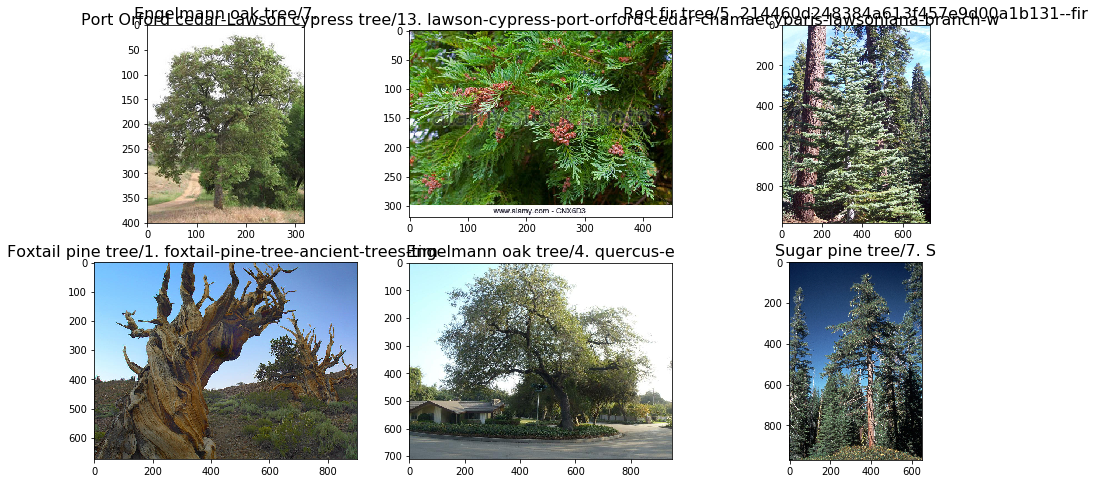

In [27]:
rand_imgs(data.trn_ds.fnames, 6)

### Determine sizes

((array([576., 285.,   4.,   0.,   0.,   0.,   0.,   1.,   0.,   1.]),
  array([ 213. ,  633.3, 1053.6, 1473.9, 1894.2, 2314.5, 2734.8, 3155.1, 3575.4, 3995.7, 4416. ]),
  <a list of 10 Patch objects>),
 (array([417., 376.,  72.,   0.,   0.,   0.,   0.,   1.,   0.,   1.]),
  array([ 200. ,  511.2,  822.4, 1133.6, 1444.8, 1756. , 2067.2, 2378.4, 2689.6, 3000.8, 3312. ]),
  <a list of 10 Patch objects>))

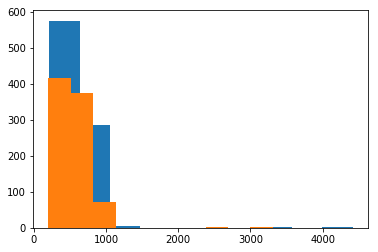

In [28]:
# create a dictionary comprehension of image sizes in the dataset
size_dist = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

row_sz,col_sz = list(zip(*size_dist.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

plt.hist(row_sz), plt.hist(col_sz)

In [29]:
np.mean(row_sz), np.mean(col_sz)

(581.5028835063437, 561.0415224913495)

In [30]:
np.median(row_sz), np.median(col_sz)

(550.0, 522.0)

In [ ]:
# Resize images above 600??

### Get learner

In [26]:
# Train last layer
learn = ConvLearner.pretrained(arch, data, ps=0.5)

# ps -> dropout parameters
# hyperparameter to control overfitting (train loss < val loss) by dropping random % of nodes in a layer

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 89%|████████▊ | 39/44 [00:02<00:00, 15.19it/s, loss=23.3]


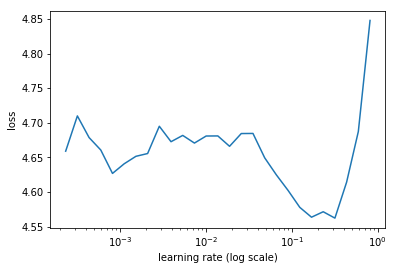

In [27]:
learn.lr_find()
# learn.sched.plot_lr()
learn.sched.plot()
# plot_loss_change(learn.sched, sma=20, y_lim=(-0.05, 0.01))

In [28]:
lr = 1e-1
lrs = np.array([1e-5, 1e-4, lr])

In [29]:
# SGDR (one restart per epoch)
learn.fit(lr, 3, cycle_len=1)

# start doing our usual minibatch gradient descent with a given learning rate (lr)
# while gradually decreasing it (fast.ai uses “cosine annealing”) until the end of the cycle

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      4.963327   4.016898   0.132812  
    1      4.311443   3.694541   0.140625                 
    2      3.824384   3.495823   0.171875                 



[3.495823, 0.171875]

In [ ]:
learn.save('224v4_last')

In [ ]:
learn.load('224v4_last')

In [ ]:
learn.set_data(get_data(400, 50))
learn.lr_find()
plot_loss_change(learn.sched, sma=20, y_lim=(-0.01, 0.01))

In [ ]:
learn.freeze()
learn.fit(lr, 3, cycle_len=1)

In [ ]:
learn.save('400v4_last')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)
lr = 1e-2
learn.fit(lrs, 3, cycle_len=1)

In [ ]:
learn.load('224v3')

In [ ]:
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
# Test Time Augmentation

log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)

In [ ]:
df = pd.DataFrame(probs)
df.columns = data.classes
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [ ]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(SUBM+filename, index=False)

In [ ]:
# submit to kaggle via cli
! kg submit {SUBM+filename} -c dog-breed-identification